In [203]:
import os
import csv
from pathlib import Path

import numpy as np
import matplotlib.pyplot as plt

from torch.utils.data import Dataset, DataLoader, Subset
import torch

from torch.utils.tensorboard import SummaryWriter

In [204]:
def del_nan_element(data_with_nan):
    """
    Delete all elements in the data which have any nan valued feature
    
    INPUT:
    @data_with_nan: data numpy array containing nan_values
    
    OUTPUT
    @data_with_nan: data numpy array inlcuding just elements per window which do have no nan_vaues in any feature
    """
    
    nan_val = np.isnan(data_with_nan) #mask for all nan_elements as 2d array [elements_per_window, features]
    nan_val = np.any(nan_val,axis = 1) #mask for all nan_rows as 1d array [elements_per_window]
    return data_with_nan[nan_val==False]

In [205]:
def create_folder_dictionary(list_of_train_BSD_states, list_of_test_BSD_states, data_path):
    """
    Create a dictionaty for testing and training containing folder names as keys and files as values
    
    INPUT:
    @list_of_train_BSD_states: list containing the training BSD states as string
    @list_of_test_BSD_states: list containing the testing BSD states as string
    @data_path: data directory containing folders for each BSD state
    
    OUTPUT
    @training_folders: dictionary folders and keys for training
    @testing_folders: dictionary folders and keys for testing
    """
    
    data_path = data_path
    state_dictionary = {
        "1":"NR01_20200317_PGS_31_BSD_31",
        "2":"NR02_20200423_PGS_31_BSD_21",
        "3":"NR03_20200424_PGS_31_BSD_11",
        "4":"NR04_20200424_PGS_31_BSD_P1",
        "5":"NR05_20200930_PGS_31_BSD_22",
        "6":"NR06_20201001_PGS_31_BSD_12",
        "7":"NR07_20201001_PGS_31_BSD_32",
        "8":"NR08_20200918_PGS_31_BSD_33",
        "9":"NR09_20200917_PGS_31_BSD_P2",
        "10":"NR10_20200502_PGS_21_BSD_31",
        "11":"NR11_20200429_PGS_21_BSD_21",
        "12":"NR12_20200429_PGS_21_BSD_11",
        "13":"NR13_20200428_PGS_21_BSD_P1",
        "14":"NR14_20200731_PGS_21_BSD_22",
        "15":"NR15_20200901_PGS_21_BSD_12",
        "16":"NR16_20200908_PGS_21_BSD_32",
        "17":"NR17_20200717_PGS_21_BSD_33",
        "18":"NR18_20200714_PGS_21_BSD_P2",
        "19":"NR19_20200505_PGS_11_BSD_31",
        "20":"NR20_20200507_PGS_11_BSD_21",
        "21":"NR21_20200508_PGS_11_BSD_11",
        "22":"NR22_20200508_PGS_11_BSD_P1",
        "23":"NR23_20200511_PGS_11_BSD_22",
        "24":"NR24_20200512_PGS_11_BSD_12",
        "25":"NR25_20200512_PGS_11_BSD_32",
        "26":"NR26_20200513_PGS_11_BSD_33",
        "27":"NR27_20200513_PGS_11_BSD_P2",
    }
    
    
    training_folders = {}
    testing_folders = {}
    
    for train_element in list_of_train_BSD_states:
        training_folders[state_dictionary[train_element]]=os.listdir(os.path.join(data_path,state_dictionary[train_element]))
    for test_element in list_of_test_BSD_states:
        testing_folders[state_dictionary[test_element]]=os.listdir(os.path.join(data_path,state_dictionary[test_element]))
    
    return training_folders, testing_folders
    

In [206]:
def get_features(path):
    """
    Creates a list of all feature names
    INPUT:
    @path: path to any BSD file since the features are the same for all files
    
    OUTPUT
    @features: list of features:
    ['C:s_ist/X', 'C:s_soll/X', 'C:s_diff/X', 'C:v_(n_ist)/X', 'C:v_(n_soll)/X', 'C:P_mech./X', 'C:Pos._Diff./X',
    'C:I_ist/X', 'C:I_soll/X', 'C:x_bottom', 'C:y_bottom', 'C:z_bottom', 'C:x_nut', 'C:y_nut', 'C:z_nut',
    'C:x_top', 'C:y_top', 'C:z_top', 'D:s_ist/X', 'D:s_soll/X', 'D:s_diff/X', 'D:v_(n_ist)/X', 'D:v_(n_soll)/X',
    'D:P_mech./X', 'D:Pos._Diff./X', 'D:I_ist/X', 'D:I_soll/X', 'D:x_bottom', 'D:y_bottom', 'D:z_bottom',
    'D:x_nut', 'D:y_nut', 'D:z_nut', 'D:x_top', 'D:y_top', 'D:z_top', 'S:x_bottom', 'S:y_bottom', 'S:z_bottom',
    'S:x_nut', 'S:y_nut', 'S:z_nut', 'S:x_top', 'S:y_top', 'S:z_top', 'S:Nominal_rotational_speed[rad/s]',
    'S:Actual_rotational_speed[µm/s]', 'S:Actual_position_of_the_position_encoder(dy/dt)[µm/s]',
    'S:Actual_position_of_the_motor_encoder(dy/dt)[µm/s]']
    """
    
    with open(path, 'r') as file:
        csvreader = csv.reader(file)
        features = next(csvreader)
    return features

In [207]:
def concatenate_data_from_BSD_state(folders, data_path, features_of_interest, window_size, overlap_size):
    """
    Concatenates all the windowed data from each file to one big torch array
    INPUT:
    @folders: dictionary containing folders (as keys) and files (as values) to downloaded
    @data_path: data directory containing folders for each BSD state
    @features_of_interest: list of features which should be included for training
    @window_size: number of elements per widow
    
    OUTPUT:
    @n_samples: number of total elements from all included files
    @x_data: torch array containing all the data elements 
    @y_data: torch array containing the labels for all elements
    """
    
    
    # arrays to collect data and label
    x_data_concatenated = None
    y_data_concatenated = None
    
    
    iterator = 0
    first = True
    
    
    for BSD_path in folders.keys(): #folder path
        for file_path in folders[BSD_path]: #file path 
            path_BSD_file = os.path.join(data_path, BSD_path, file_path) # concatenate the data_path, folder and file path
            #in first iteration get a list if all features
            if first == True:
                features = get_features(path_BSD_file)
                
            data_BSD_file = np.genfromtxt(path_BSD_file, dtype = np.dtype('d'), delimiter=',')[1:,:] #write csv in numpy
            feature_index_list = np.where(np.isin(features, features_of_interest)) #get index for all features of interest
            data_BSD_file = data_BSD_file[:,feature_index_list] #slice numpy array such that just features of interest are included
            data_BSD_file = np.squeeze(data_BSD_file, axis = 1) # one unnecessary extra dimension was created while slicing
            data_BSD_file = del_nan_element(data_BSD_file) #delete all elements with any nan feature
            
            #rewrite labels as BSD_condition_1 = 0, BSD_condition_2 = 1, BSD_condition_3 = 2, BSD_condition_P1 = 3
            label = BSD_path[-2] #take the first number of the BSD state for class label
            if label == "P":
                label = int(3)
            else:
                label =int(int(label)-1)
            
            
            
            #concatenate the data from each file in one numpy array
            if  first == True: #overwrite variable
                x_data_concatenated = np.copy(data_BSD_file)
                y_data_concatenated = np.copy(np.asarray([label]*np.shape(data_BSD_file)[0]))
                first = False
            else: #concatenate data numpy arrays
                x_data_concatenated = np.concatenate((x_data_concatenated, data_BSD_file), axis=0)
                y_data_concatenated = np.concatenate((y_data_concatenated,np.asarray([label]*np.shape(data_BSD_file)[0])), axis=0)
            
            iterator +=1
            print(f"{iterator}/{len(folders.keys())*len(folders[list(folders.keys())[0]])} folders downloaded")
            print(f"downloaded folder: {BSD_path}/{file_path}")
            print(f"Shape of collected datafram: X_shape: {np.shape(x_data_concatenated)}, Y_shape: {np.shape(y_data_concatenated)}")
    
    #generate torch array
    n_samples = np.shape(x_data_concatenated)[0]
    
    return n_samples, x_data_concatenated, y_data_concatenated

In [208]:
class TimeSeriesData(Dataset):
    """
    Class for creating dataset using PyTorch data primitive Dataset. An instance of this class can be used in the 
    PyTorch data primitive Dataloader
    
    The following patameters can be adjusted:
    @windwo_size: Size of window which is used as Input in CNN
    @feature_of_interest: List of all features which should be used in the CNN
    @list_of_train_BSD_states: List of BSD states which should be used for training. Be careful at least 4 BSD
    states representing the 4 different classes should be included for the training
    @list_of_test_BSD_states: List of BSD states which should be used for testing
    """
    
    
    def __init__(self, domain):
        window_size = 1024
        overlap_size = 300
        features_of_interest =['C:s_ist/X', 'C:s_soll/X', 'C:s_diff/X', 'C:v_(n_ist)/X', 'C:v_(n_soll)/X', 'C:P_mech./X', 'C:Pos._Diff./X',
                                'C:I_ist/X', 'C:I_soll/X', 'C:x_bottom', 'C:y_bottom', 'C:z_bottom', 'C:x_nut', 'C:y_nut', 'C:z_nut',
                                'C:x_top', 'C:y_top', 'C:z_top', 'D:s_ist/X', 'D:s_soll/X', 'D:s_diff/X', 'D:v_(n_ist)/X', 'D:v_(n_soll)/X',
                                'D:P_mech./X', 'D:Pos._Diff./X', 'D:I_ist/X', 'D:I_soll/X', 'D:x_bottom', 'D:y_bottom', 'D:z_bottom',
                                'D:x_nut', 'D:y_nut', 'D:z_nut', 'D:x_top', 'D:y_top', 'D:z_top', 'S:x_bottom', 'S:y_bottom', 'S:z_bottom',
                                'S:x_nut', 'S:y_nut', 'S:z_nut', 'S:x_top', 'S:y_top', 'S:z_top', 'S:Nominal_rotational_speed[rad/s]',
                                'S:Actual_rotational_speed[µm/s]', 'S:Actual_position_of_the_position_encoder(dy/dt)[µm/s]',
                                'S:Actual_position_of_the_motor_encoder(dy/dt)[µm/s]'
                              ]
        
        
        
    #['C:s_ist/X', 'C:s_soll/X', 'C:s_diff/X', 'C:v_(n_ist)/X', 'C:v_(n_soll)/X', 'C:P_mech./X', 'C:Pos._Diff./X',
    #'C:I_ist/X', 'C:I_soll/X', 'C:x_bottom', 'C:y_bottom', 'C:z_bottom', 'C:x_nut', 'C:y_nut', 'C:z_nut',
    #'C:x_top', 'C:y_top', 'C:z_top', 'D:s_ist/X', 'D:s_soll/X', 'D:s_diff/X', 'D:v_(n_ist)/X', 'D:v_(n_soll)/X',
    #'D:P_mech./X', 'D:Pos._Diff./X', 'D:I_ist/X', 'D:I_soll/X', 'D:x_bottom', 'D:y_bottom', 'D:z_bottom',
    #'D:x_nut', 'D:y_nut', 'D:z_nut', 'D:x_top', 'D:y_top', 'D:z_top','S:x_bottom', 'S:y_bottom', 'S:z_bottom',
    #'S:x_nut', 'S:y_nut', 'S:z_nut', 'S:x_top', 'S:y_top', 'S:z_top', 'S:Nominal_rotational_speed[rad/s]',
    #'S:Actual_rotational_speed[µm/s]', 'S:Actual_position_of_the_position_encoder(dy/dt)[µm/s]',
    #'S:Actual_position_of_the_motor_encoder(dy/dt)[µm/s]']
        number_of_files_per_BDS_state = 10
        
        #list_of_train_BSD_states = ["BSD_31", "BSD_21", "BSD_11", "BSD_P1"]
        #list_of_test_BSD_states = ["BSD_32", "BSD_22", "BSD_12", "BSD_P2"]
        
        list_of_train_BSD_states = ["1", "2", "3", "4", "10", "11", "12", "13", "19", "20", "21", "22"]
        list_of_test_BSD_states = ["5", "6", "7", "9", "14", "15", "16", "18", "23", "24", "25", "27"]
        
        #data_path = os.path.join(os.path.abspath(os.path.join(os.getcwd(), os.pardir)), "data")
        
        data_path = Path(os.getcwd()).parents[1]
        data_path = os.path.join(data_path, "data")
        
        training_folders, testing_folders = create_folder_dictionary(list_of_train_BSD_states, list_of_test_BSD_states, data_path)
        folders_domain = {}
        folders_domain["test"] = testing_folders
        folders_domain["train"] = training_folders
        
        
        self.n_samples, self.x_data_concatenated, self.y_data_concatenated = concatenate_data_from_BSD_state(folders_domain[domain], data_path, features_of_interest, window_size, overlap_size)
        
                  
    # support indexing such that dataset[i] can be used to get i-th sample
    def __getitem__(self, index):
        return self.x_data_concatenated[index], self.y_data_concatenated[index]

    # we can call len(dataset) to return the size
    def __len__(self):
        return self.n_samples





In [209]:

#DATASET TEST (domain = "test")
dataset_test = TimeSeriesData("test")

#DATASET TRAIN (domain = "train")
dataset_train = TimeSeriesData("train")

1/120 folders downloaded
downloaded folder: NR05_20200930_PGS_31_BSD_22/478_2020_09_30.csv
Shape of collected datafram: X_shape: (16384, 49), Y_shape: (16384,)
2/120 folders downloaded
downloaded folder: NR05_20200930_PGS_31_BSD_22/480_2020_09_30.csv
Shape of collected datafram: X_shape: (32768, 49), Y_shape: (32768,)
3/120 folders downloaded
downloaded folder: NR05_20200930_PGS_31_BSD_22/477_2020_09_30.csv
Shape of collected datafram: X_shape: (49152, 49), Y_shape: (49152,)
4/120 folders downloaded
downloaded folder: NR05_20200930_PGS_31_BSD_22/476_2020_09_30.csv
Shape of collected datafram: X_shape: (65536, 49), Y_shape: (65536,)
5/120 folders downloaded
downloaded folder: NR05_20200930_PGS_31_BSD_22/481_2020_09_30.csv
Shape of collected datafram: X_shape: (81920, 49), Y_shape: (81920,)
6/120 folders downloaded
downloaded folder: NR05_20200930_PGS_31_BSD_22/479_2020_09_30.csv
Shape of collected datafram: X_shape: (98304, 49), Y_shape: (98304,)
7/120 folders downloaded
downloaded fold

52/120 folders downloaded
downloaded folder: NR15_20200901_PGS_21_BSD_12/428_2020_09_01.csv
Shape of collected datafram: X_shape: (851968, 49), Y_shape: (851968,)
53/120 folders downloaded
downloaded folder: NR15_20200901_PGS_21_BSD_12/427_2020_09_01.csv
Shape of collected datafram: X_shape: (868352, 49), Y_shape: (868352,)
54/120 folders downloaded
downloaded folder: NR15_20200901_PGS_21_BSD_12/432_2020_09_01.csv
Shape of collected datafram: X_shape: (884736, 49), Y_shape: (884736,)
55/120 folders downloaded
downloaded folder: NR15_20200901_PGS_21_BSD_12/433_2020_09_01.csv
Shape of collected datafram: X_shape: (901120, 49), Y_shape: (901120,)
56/120 folders downloaded
downloaded folder: NR15_20200901_PGS_21_BSD_12/429_2020_09_01.csv
Shape of collected datafram: X_shape: (917504, 49), Y_shape: (917504,)
57/120 folders downloaded
downloaded folder: NR15_20200901_PGS_21_BSD_12/434_2020_09_01.csv
Shape of collected datafram: X_shape: (933888, 49), Y_shape: (933888,)
58/120 folders downloa

102/120 folders downloaded
downloaded folder: NR25_20200512_PGS_11_BSD_32/339_2020_05_12.csv
Shape of collected datafram: X_shape: (1671168, 49), Y_shape: (1671168,)
103/120 folders downloaded
downloaded folder: NR25_20200512_PGS_11_BSD_32/340_2020_05_12.csv
Shape of collected datafram: X_shape: (1687552, 49), Y_shape: (1687552,)
104/120 folders downloaded
downloaded folder: NR25_20200512_PGS_11_BSD_32/341_2020_05_12.csv
Shape of collected datafram: X_shape: (1703936, 49), Y_shape: (1703936,)
105/120 folders downloaded
downloaded folder: NR25_20200512_PGS_11_BSD_32/338_2020_05_12.csv
Shape of collected datafram: X_shape: (1720320, 49), Y_shape: (1720320,)
106/120 folders downloaded
downloaded folder: NR25_20200512_PGS_11_BSD_32/337_2020_05_12.csv
Shape of collected datafram: X_shape: (1736704, 49), Y_shape: (1736704,)
107/120 folders downloaded
downloaded folder: NR25_20200512_PGS_11_BSD_32/335_2020_05_12.csv
Shape of collected datafram: X_shape: (1753088, 49), Y_shape: (1753088,)
108/

33/120 folders downloaded
downloaded folder: NR04_20200424_PGS_31_BSD_P1/086_2020_04_24.csv
Shape of collected datafram: X_shape: (540672, 49), Y_shape: (540672,)
34/120 folders downloaded
downloaded folder: NR04_20200424_PGS_31_BSD_P1/087_2020_04_24.csv
Shape of collected datafram: X_shape: (557056, 49), Y_shape: (557056,)
35/120 folders downloaded
downloaded folder: NR04_20200424_PGS_31_BSD_P1/080_2020_04_24.csv
Shape of collected datafram: X_shape: (573440, 49), Y_shape: (573440,)
36/120 folders downloaded
downloaded folder: NR04_20200424_PGS_31_BSD_P1/088_2020_04_24.csv
Shape of collected datafram: X_shape: (589824, 49), Y_shape: (589824,)
37/120 folders downloaded
downloaded folder: NR04_20200424_PGS_31_BSD_P1/082_2020_04_24.csv
Shape of collected datafram: X_shape: (606208, 49), Y_shape: (606208,)
38/120 folders downloaded
downloaded folder: NR04_20200424_PGS_31_BSD_P1/085_2020_04_24.csv
Shape of collected datafram: X_shape: (622592, 49), Y_shape: (622592,)
39/120 folders downloa

84/120 folders downloaded
downloaded folder: NR19_20200505_PGS_11_BSD_31/196_2020_05_05.csv
Shape of collected datafram: X_shape: (1376256, 49), Y_shape: (1376256,)
85/120 folders downloaded
downloaded folder: NR19_20200505_PGS_11_BSD_31/199_2020_05_05.csv
Shape of collected datafram: X_shape: (1392640, 49), Y_shape: (1392640,)
86/120 folders downloaded
downloaded folder: NR19_20200505_PGS_11_BSD_31/204_2020_05_05.csv
Shape of collected datafram: X_shape: (1409024, 49), Y_shape: (1409024,)
87/120 folders downloaded
downloaded folder: NR19_20200505_PGS_11_BSD_31/203_2020_05_05.csv
Shape of collected datafram: X_shape: (1425408, 49), Y_shape: (1425408,)
88/120 folders downloaded
downloaded folder: NR19_20200505_PGS_11_BSD_31/202_2020_05_05.csv
Shape of collected datafram: X_shape: (1441792, 49), Y_shape: (1441792,)
89/120 folders downloaded
downloaded folder: NR19_20200505_PGS_11_BSD_31/200_2020_05_05.csv
Shape of collected datafram: X_shape: (1458176, 49), Y_shape: (1458176,)
90/120 fol

(3932160,)
(3932160, 1)
(3932160, 2)
          feature_name feature_data
0        train_class_0    -712.1329
1        train_class_0    -712.1329
2        train_class_0    -712.1329
3        train_class_0    -712.1329
4        train_class_0    -712.1329
...                ...          ...
3932155   test_class_3   -1249.9123
3932156   test_class_3   -1249.9123
3932157   test_class_3   -1249.9123
3932158   test_class_3   -1249.9123
3932159   test_class_3   -1249.9123

[3932160 rows x 2 columns]


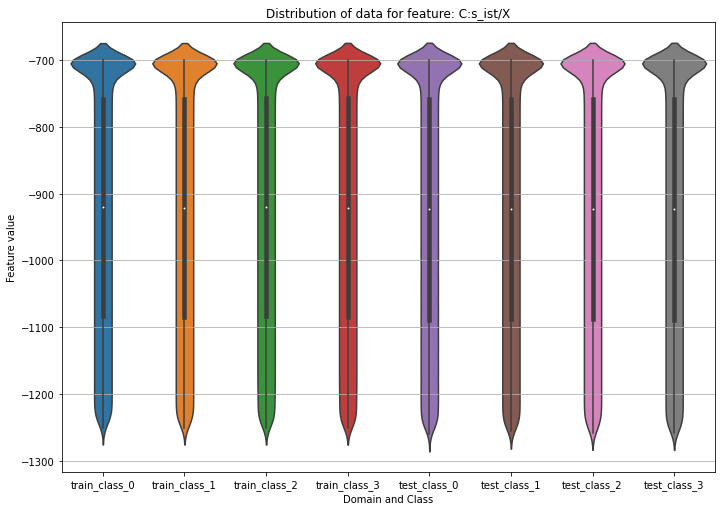

(3932160,)
(3932160, 1)
(3932160, 2)
          feature_name feature_data
0        train_class_0     -700.001
1        train_class_0     -700.001
2        train_class_0     -700.001
3        train_class_0     -700.001
4        train_class_0     -700.001
...                ...          ...
3932155   test_class_3   -1293.8568
3932156   test_class_3   -1293.8568
3932157   test_class_3   -1293.8568
3932158   test_class_3   -1293.8568
3932159   test_class_3   -1293.8568

[3932160 rows x 2 columns]


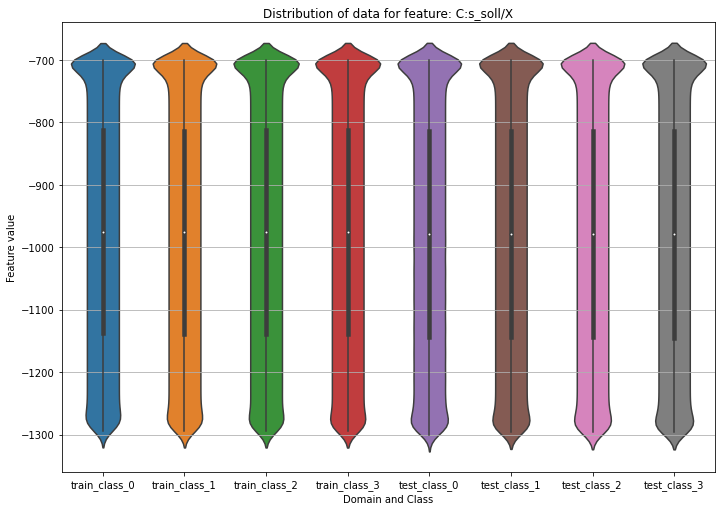

(3932160,)
(3932160, 1)
(3932160, 2)
          feature_name feature_data
0        train_class_0       4.9209
1        train_class_0       4.9209
2        train_class_0       4.9209
3        train_class_0       4.9209
4        train_class_0       4.9209
...                ...          ...
3932155   test_class_3      -7.9754
3932156   test_class_3      -7.9754
3932157   test_class_3      -7.9754
3932158   test_class_3      -7.9754
3932159   test_class_3      -7.9754

[3932160 rows x 2 columns]


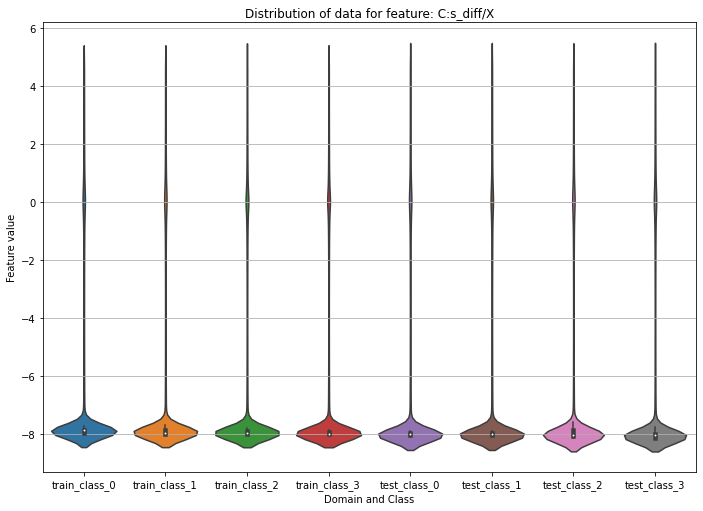

(3932160,)
(3932160, 1)
(3932160, 2)
          feature_name  feature_data
0        train_class_0   14816.09195
1        train_class_0   14816.09195
2        train_class_0   14786.33881
3        train_class_0   14786.33881
4        train_class_0   14756.58268
...                ...           ...
3932155   test_class_3  -23939.89414
3932156   test_class_3  -23933.02917
3932157   test_class_3  -23933.02917
3932158   test_class_3  -23936.46091
3932159   test_class_3  -23936.46091

[3932160 rows x 2 columns]


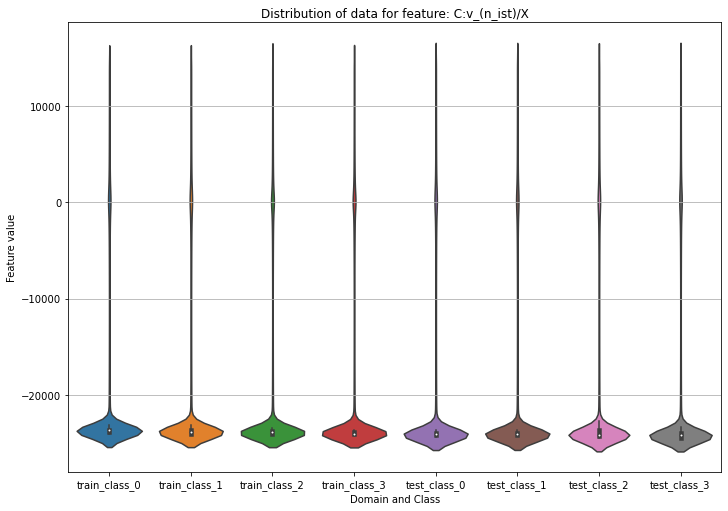

(3932160,)
(3932160, 1)
(3932160, 2)
          feature_name  feature_data
0        train_class_0   14794.48229
1        train_class_0   14794.48229
2        train_class_0   14762.83967
3        train_class_0   14762.83967
4        train_class_0   14731.05252
...                ...           ...
3932155   test_class_3  -23930.09663
3932156   test_class_3  -23928.26527
3932157   test_class_3  -23928.26527
3932158   test_class_3  -23926.43392
3932159   test_class_3  -23926.43392

[3932160 rows x 2 columns]


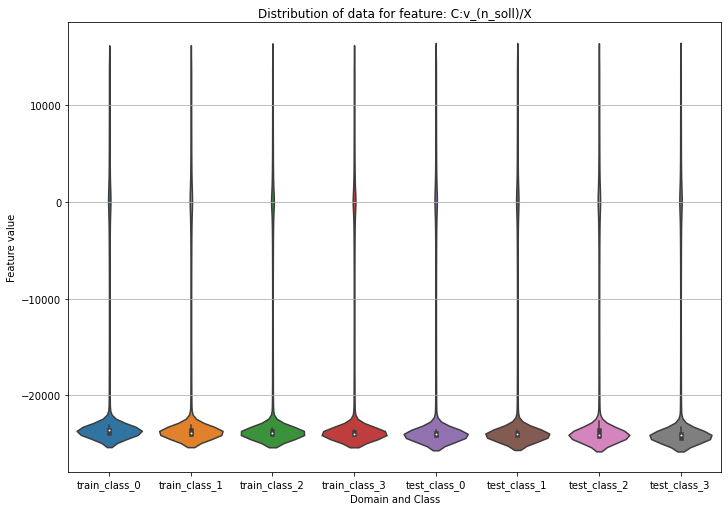

(3932160,)
(3932160, 1)
(3932160, 2)
          feature_name feature_data
0        train_class_0       -1.607
1        train_class_0       -1.604
2        train_class_0       -1.618
3        train_class_0       -1.594
4        train_class_0       -1.596
...                ...          ...
3932155   test_class_3       -0.254
3932156   test_class_3       -0.226
3932157   test_class_3       -0.217
3932158   test_class_3       -0.218
3932159   test_class_3       -0.235

[3932160 rows x 2 columns]


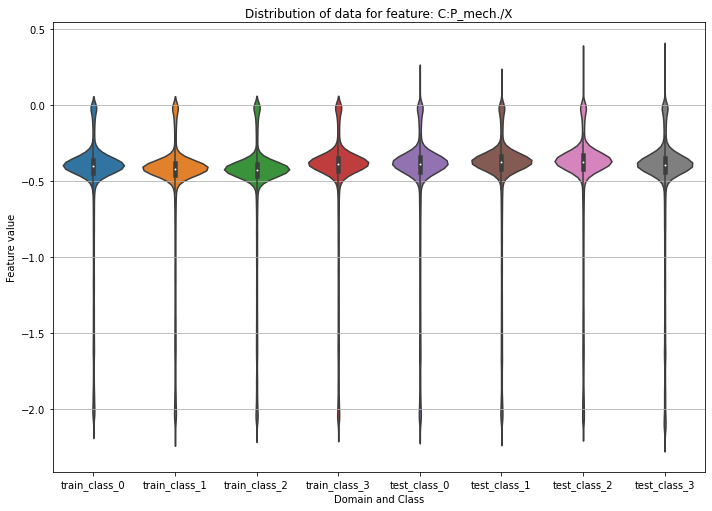

(3932160,)
(3932160, 1)
(3932160, 2)
          feature_name feature_data
0        train_class_0       0.3298
1        train_class_0       0.3298
2        train_class_0       0.3298
3        train_class_0       0.3298
4        train_class_0       0.3298
...                ...          ...
3932155   test_class_3       0.0959
3932156   test_class_3       0.0959
3932157   test_class_3       0.0959
3932158   test_class_3       0.0959
3932159   test_class_3       0.0959

[3932160 rows x 2 columns]


In [ ]:
import seaborn as sns
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib import rcParams

y_test = dataset_test.y_data_concatenated
y_train = dataset_train.y_data_concatenated
x_test = dataset_test.x_data_concatenated
x_train = dataset_train.x_data_concatenated

#np.savetxt('test.out', x_test,  delimiter=',')
classes = [0,1,2,3]
features_of_interest =['C:s_ist/X', 'C:s_soll/X', 'C:s_diff/X', 'C:v_(n_ist)/X', 'C:v_(n_soll)/X', 'C:P_mech./X', 'C:Pos._Diff./X',
                        'C:I_ist/X', 'C:I_soll/X', 'C:x_bottom', 'C:y_bottom', 'C:z_bottom', 'C:x_nut', 'C:y_nut', 'C:z_nut',
                        'C:x_top', 'C:y_top', 'C:z_top', 'D:s_ist/X', 'D:s_soll/X', 'D:s_diff/X', 'D:v_(n_ist)/X', 'D:v_(n_soll)/X',
                        'D:P_mech./X', 'D:Pos._Diff./X', 'D:I_ist/X', 'D:I_soll/X', 'D:x_bottom', 'D:y_bottom', 'D:z_bottom',
                        'D:x_nut', 'D:y_nut', 'D:z_nut', 'D:x_top', 'D:y_top', 'D:z_top', 'S:x_bottom', 'S:y_bottom', 'S:z_bottom',
                        'S:x_nut', 'S:y_nut', 'S:z_nut', 'S:x_top', 'S:y_top', 'S:z_top', 'S:Nominal_rotational_speed[rad/s]',
                        'S:Actual_rotational_speed[µm/s]', 'S:Actual_position_of_the_position_encoder(dy/dt)[µm/s]',
                        'S:Actual_position_of_the_motor_encoder(dy/dt)[µm/s]'
                      ]

domain_x = [x_train, x_test]
domain_y = [y_train, y_test]
domain = ["train", "test"]

img_path = Path(os.getcwd())
img_path = os.path.join(img_path, "img")

feature_size = len(features_of_interest)

for feature in range(feature_size):
    feature_data = []
    feature_name = []
    for domain_iter in range(2):
        for cla in classes:
            mask_1 = np.tile(domain_y[domain_iter],(feature_size,1)).transpose()
            mask_2 = np.ma.masked_equal(mask_1, cla)
            mask_3 = np.ma.getmask(mask_2)
            x_masked = domain_x[domain_iter][mask_3==True].reshape((-1,feature_size))
            feature_data = feature_data + x_masked[:,feature].tolist()
            feature_name = feature_name + [domain[domain_iter]+"_class_"+str(cla)]*len(x_masked[:,feature])
    print(np.shape(feature_name))
    feature_data = np.expand_dims(np.asarray(feature_data), axis=1)
    feature_name = np.expand_dims(np.asarray(feature_name), axis=1)
    print(np.shape(feature_name))
    data = np.concatenate((feature_name, feature_data), axis = 1)
    print(np.shape(data))
    
    df = pd.DataFrame(data, columns = ["feature_name", "feature_data"])
    print(df)

    # figure size in inches
    rcParams['figure.figsize'] = 11.7,8.27

    fig, axes = plt.subplots()
    feature_name = df.feature_name
    df = df.explode('feature_data')
    df['feature_data'] = df['feature_data'].astype('float')
    feature_data = df.feature_data
    
    sns.violinplot(x=feature_name, y=feature_data, data=df)
    
    feature_name = features_of_interest[feature]
    axes.set_title(f'Distribution of data for feature: {feature_name}')

    axes.yaxis.grid(True)
    axes.set_xlabel('Domain and Class')
    axes.set_ylabel('Feature value')

    plt.show()

    if "/" in feature_name:
        feature_name = feature_name.replace("/", "_")
        feature_name = feature_name + ".png"
    img_name = os.path.join(img_path, feature_name)
    #fig.savefig(img_name, dpi=fig.dpi)
    


In [ ]:
assert np.shape(dataset_test[1]) == np.shape(dataset_train[1])

classes = [0,1,2,3]
feature_size = np.shape(dataset_test[1])

for feature in range(feature_size):
    for cla in classes:
        